In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os

In [2]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 7

In [11]:
hit_df = pd.read_csv('../data/raw/24-03-28 EOP tracking - Systems.csv')
systems_df = pd.read_csv('../data/raw/Beaker validation domains - hit_proteins.csv')
domains_df = pd.read_csv('../data/raw/Beaker validation domains - hhpred_domains.csv')
tm_df = pd.read_csv('../data/raw/Beaker validation domains - tm.csv')
cc_df = pd.read_csv('../data/raw/Beaker validation domains - coiled_coil.csv')
display_name_df = pd.read_csv('../data/raw/Beaker validation domains - system_display_names.csv')

In [4]:
phage_order = ['T5', 'Bas26', 
               'Candy', 'RB69', 'T4', 
               'Bas63', 
               'Bas60', 
               'Bas50', 
               'Bas69', 
               'Bas67', 'T3', 'T7', 
               'Lambda', 
               'SECphi17', 
               'Bas19', 'Bas25', 'Bas21', 
               'SECphi18', 
               'Bas1', 'Bas3', 'Bas11', 'Bas9', 'Bas6', 'SECphi27']

In [12]:
system_order = (systems_df.groupby('working_id')
                .agg(max_prediction=('log_odds', 'max'))
                .reset_index()
                .sort_values('max_prediction', ascending=False)
                ['working_id'].to_list())
relevant_sys_order = [x for x in system_order if x in display_name_df['working_id'].to_list()]
display_name_order = (display_name_df.set_index('working_id')
                      .loc[relevant_sys_order, 'DS_name'].to_list())

In [13]:
hit_df = (hit_df.merge(display_name_df.rename(columns={'working_id': 'System'}), 
                       how='inner', on='System'))
hit_df['-log(EOP)'] = [0 if x < 0.5 else x for x in hit_df['-log(EOP)'] ]
hit_df['Phage'] = pd.Categorical(hit_df['Phage'], categories=phage_order)
hit_df['System'] = pd.Categorical(hit_df['System'], categories=system_order)
hit_df['smaller_plaque'] = ((hit_df['Smaller Plaque Size'] == 'Y') & (hit_df['-log(EOP)'] < 1))
hit_df['hit'] = True
hit_df['DS_name'] = pd.Categorical(hit_df['DS_name'], categories=display_name_order)

## Plot all hits

In [14]:
wide_hit_df = hit_df.pivot(columns='Phage', index='System', values='-log(EOP)').fillna(0)
wide_hit_annot = (hit_df.pivot(columns='Phage', index='System', values='smaller_plaque')
                  .fillna(False).applymap(lambda x: 's' if x else ''))


In [15]:
sys_height = 0.25

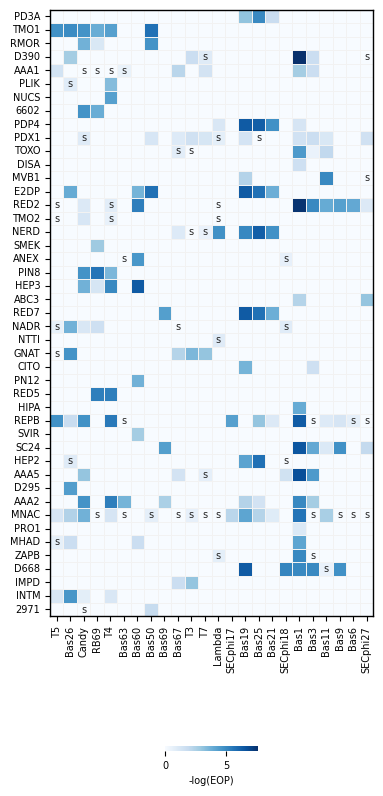

In [16]:
fig, ax = plt.subplots(figsize=(sys_height*wide_hit_df.shape[1], sys_height*len(wide_hit_df)))
sns.heatmap(wide_hit_df,  
            linecolor='#F2F2F2', linewidth=0.5,
            ax=ax, cmap='Blues', cbar=True, 
            cbar_kws={'shrink': 0.2, 
                      "orientation": "horizontal",
                      'label': '-log(EOP)'}, 
            square=True)
sns.heatmap(wide_hit_df,  
            linecolor='#F2F2F2', linewidth=0.5,
            ax=ax, cmap='Blues', 
            annot=wide_hit_annot, fmt="", cbar=False)
plt.xticks(rotation=90)
plt.xlabel(None)
plt.ylabel(None)
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1)  # Adjust border thickness if necessary
plt.savefig('../figures/all_hit_heatmap.svg', dpi=300, bbox_inches='tight')

In [18]:
wide_binary_hit_df = hit_df.pivot(columns='Phage', index='DS_name', values='hit').fillna(False)

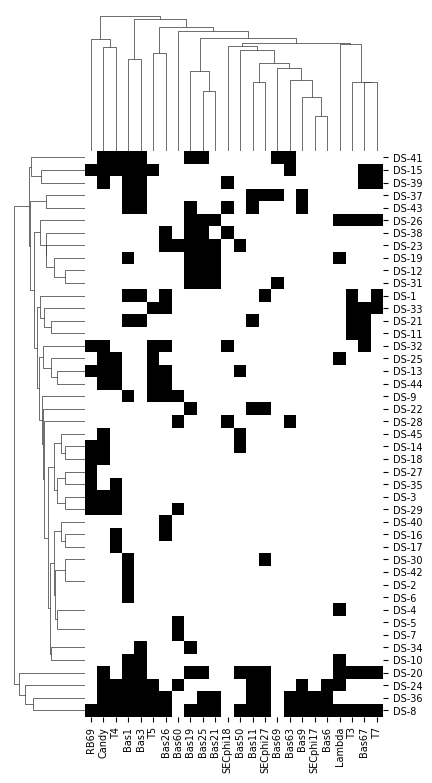

In [19]:
sns.clustermap(wide_binary_hit_df, cmap='Greys', figsize=(4.5,8), cbar_pos=None)
plt.ylabel('')
plt.xlabel('')
plt.savefig('../figures/hit_clustermap.svg', dpi=300, bbox_inches='tight')

## Plot novel domain systems

In [22]:
highlight_systems = ['D390', 'DISA', 'PIN8', 'NTTI', 'PN12',
                     'HIPA', 'SVIR', 'MNAC', 'MHAD', 'ZAPB', 'IMPD']

In [23]:
highlight_hit_df = wide_hit_df.loc[wide_hit_df.index.isin(highlight_systems), :]
highlight_hit_annot = wide_hit_annot.loc[wide_hit_annot.index.isin(highlight_systems), :]

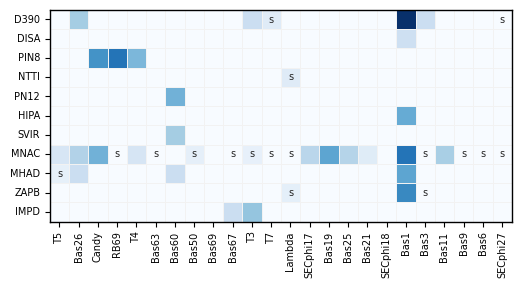

In [24]:
fig, ax = plt.subplots(figsize=(sys_height*highlight_hit_df.shape[1], sys_height*len(highlight_hit_df)))
sns.heatmap(highlight_hit_df,  
            linecolor='#F2F2F2', linewidth=0.5,
            ax=ax, cmap='Blues', cbar=False, 
            cbar_kws={'shrink': 0.25, 
                      'label': '-log(EOP)'}, square=True)
sns.heatmap(highlight_hit_df,  
            linecolor='#F2F2F2', linewidth=0.5,
            ax=ax, cmap='Blues', 
            annot=highlight_hit_annot, fmt="", cbar=False, square=True)
plt.xticks(rotation=90)
plt.xlabel(None)
plt.ylabel(None)
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1)  # Adjust border thickness if necessary
plt.savefig('../figures/highlight_hit_heatmap.svg', dpi=300, bbox_inches='tight')

## Plot other systems

In [25]:
other_hit_df = wide_hit_df.loc[~wide_hit_df.index.isin(highlight_systems), :]
other_hit_annot = wide_hit_annot.loc[~wide_hit_annot.index.isin(highlight_systems), :]

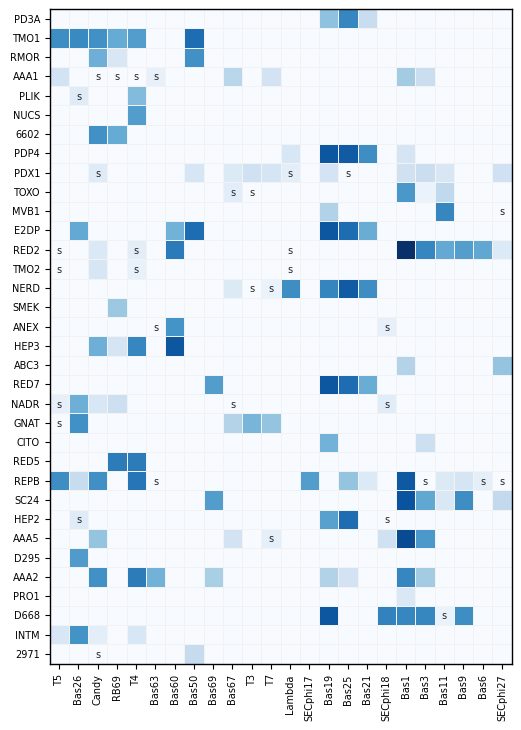

In [26]:
fig, ax = plt.subplots(figsize=(sys_height*other_hit_df.shape[1], sys_height*len(other_hit_df)))
sns.heatmap(other_hit_df,  
            linecolor='#F2F2F2', linewidths=0.5,
            ax=ax, cmap='Blues', cbar=False, 
            cbar_kws={'shrink': 0.25, 
                      'label': '-log(EOP)'}, square=True)
sns.heatmap(other_hit_df,  
            linecolor='#F2F2F2', linewidths=0.5,
            ax=ax, cmap='Blues', 
            annot=other_hit_annot, fmt="", cbar=False, square=True)
plt.xticks(rotation=90)
plt.xlabel(None)
plt.ylabel(None)
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1)  # Adjust border thickness if necessary
plt.savefig('../figures/other_hit_heatmap.svg', dpi=300, bbox_inches='tight')

## Plot systems

In [27]:
tm_df['Domain Name'] = 'TM'
cc_df['Domain Name'] = 'CC'
cat_domains = pd.concat([domains_df, 
                         tm_df, 
                         cc_df])

In [31]:
def get_df_q_cov(row):
    if not pd.isna(row['defense_homolog_names']):
        return 1
    elif not pd.isna(row['HHpred_defense_homolog_q_cov']):
        return row['HHpred_defense_homolog_q_cov']
    else:
        return 0

<Axes: xlabel='df_q_cov', ylabel='Count'>

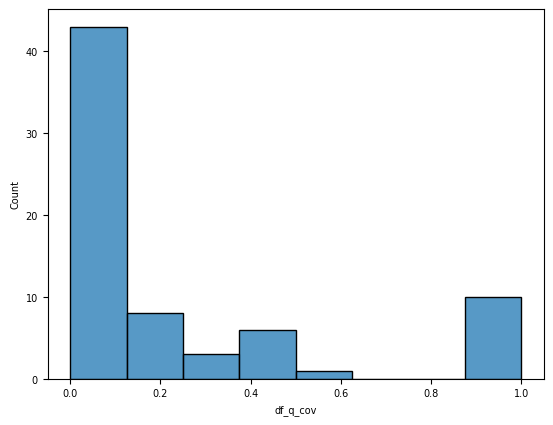

In [32]:
systems_df['df_q_cov'] = systems_df.apply(get_df_q_cov, axis=1)
sns.histplot(systems_df['df_q_cov'])

In [33]:
def plot_system(system_df, cat_domains, show_scale=True, show_prob_cmap=False, 
                hhpred_cmap=None, sys_height=sys_height, clip_on=False):
    sys_height += -0.05
    if hhpred_cmap is None:
        hhpred_cmap = sns.color_palette("light:#E8020B", as_cmap=True)
    total_length = system_df['product_length'].sum() + 3*len(system_df)
    fig, ax = plt.subplots(figsize=(3.9, sys_height))
    ax.set_clip_on(clip_on)
    x_offset = 0
    if system_df['strand'].to_list()[0] == '-':
        system_df = system_df.sort_values('start', ascending=False).reset_index(drop=True)
    else:
        system_df = system_df.sort_values('start', ascending=True).reset_index(drop=True)
    for _, protein_series in system_df.iterrows():
        product_accession = protein_series['product_accession']
        protein_length = protein_series['product_length']
        protein_edgecolor = 'black'
        # plot individual domains
        domain_df = cat_domains[cat_domains['product_accession'] == product_accession]
        for _, domain_series in domain_df.iterrows():
            textcolor='black'
            start = domain_series['start']
            end = domain_series['end']
            label = domain_series['Domain Name']
            probability = domain_series['Domain Prob']
            if not pd.isnull(probability):
                color = hhpred_cmap(probability)                   
            else:
                color = 'darkgrey'
            domain_rect = patches.Rectangle((x_offset + start, -3), end - start, 6, facecolor=color, linewidth=0, clip_on=clip_on)
            ax.add_patch(domain_rect)
            ax.text(x_offset + ((start + end) / 2), -0.3, label, ha='center', va='center', fontdict={'color': textcolor})
        arrow_width = 6
        protein_arrow = patches.FancyArrow(x_offset, 0, protein_length, 0, 
                                           width=arrow_width, facecolor='none', edgecolor=protein_edgecolor, linewidth=1, 
                                           length_includes_head=True, head_width=arrow_width, head_length=0.05*total_length, 
                                           clip_on=clip_on)
        ax.add_patch(protein_arrow)
        if protein_series['df_q_cov'] > 0.5:
            ax.text(x_offset + protein_length - 0.02*total_length, 2.8, '*', ha='center', va='center', fontdict={'color': 'black'})
        x_offset += protein_length + 3
    ax.axis('off')
    if show_scale: 
        ax.hlines(-4, 0, 100, linewidth=1, color='black', zorder=0, clip_on=clip_on)
    if show_prob_cmap:
        # Add a colorbar legend
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("bottom", size="150%", )
        norm = plt.Normalize(0, 1)
        cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=hhpred_cmap), cax=cax, orientation='horizontal', 
                          fraction=0.046, pad=0.04)
        cb.set_label("HHPred Probability")

/state/partition1/slurm_tmp/27679715.0.0/ipykernel_367058/2605934906.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(3.9, sys_height))


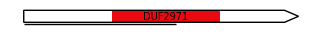

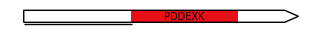

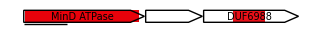

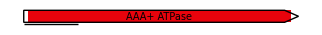

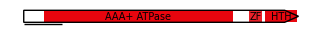

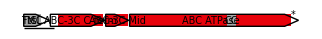

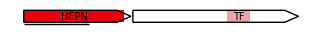

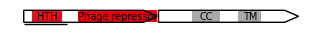

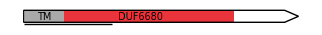

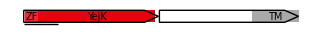

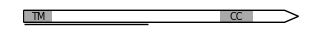

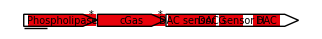

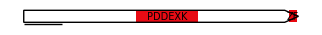

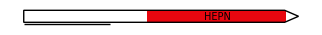

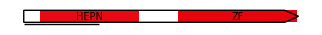

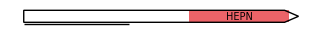

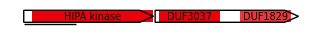

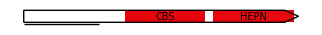

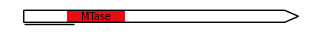

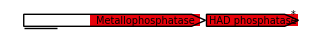

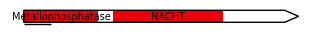

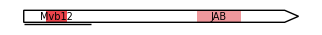

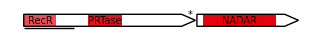

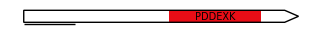

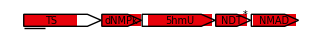

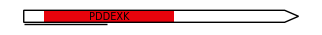

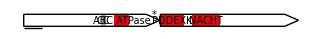

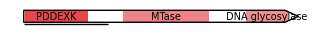

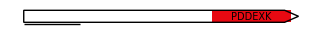

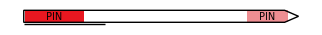

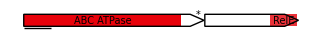

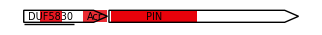

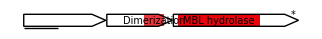

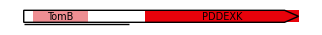

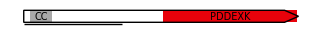

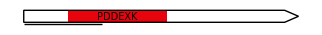

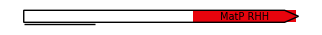

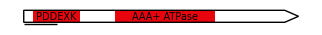

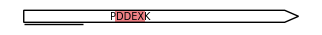

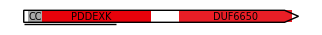

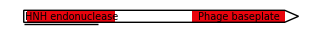

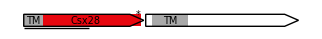

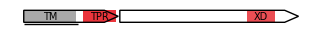

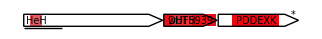

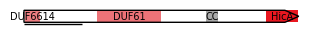

In [34]:
domain_figure_dir = '../figures/beaker_validation_domains/'
if 'beaker_validation_domains' in os.listdir('../figures/'):
    os.system('rm -r ' + domain_figure_dir)
os.mkdir(domain_figure_dir)
for system, system_df in (systems_df
                          .sort_values(['working_id', 
                                        'protein_num'])
                          .groupby('working_id')):
    plot_system(system_df, cat_domains)
    plt.savefig(domain_figure_dir + 'hit_system_' + system + '.svg', dpi=300, bbox_inches='tight')

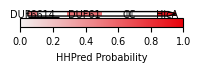

In [39]:
plot_system(system_df, cat_domains, show_prob_cmap=True)
plt.savefig(domain_figure_dir + 'hit_system_cmap' + '.svg', dpi=300, bbox_inches='tight')